In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from keras import utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
from zipfile import ZipFile
dataset = "/content/Group 1.0.zip"
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("The dataset is extracted.")

The dataset is extracted.


In [3]:
dataset_directory = '/content/Group 1.0/Chess Dataset'

In [4]:
# Function to load the dataset
def load_dataset(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Assumes each subdirectory is a class

    for i, class_name in enumerate(class_names):
        class_directory = os.path.join(directory, class_name)
        for filename in os.listdir(class_directory):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(class_directory, filename)
                image = Image.open(image_path)
                image = image.resize((227, 227))  # Resize if necessary
                image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                labels.append(i)  # Store index of the class

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, class_names

In [5]:
# Usage example
images, labels, class_names = load_dataset(dataset_directory)

In [6]:
# Print shape of loaded data for verification
print("Loaded images shape:", images.shape)
print("Loaded labels shape:", labels.shape)

Loaded images shape: (534, 227, 227, 3)
Loaded labels shape: (534,)


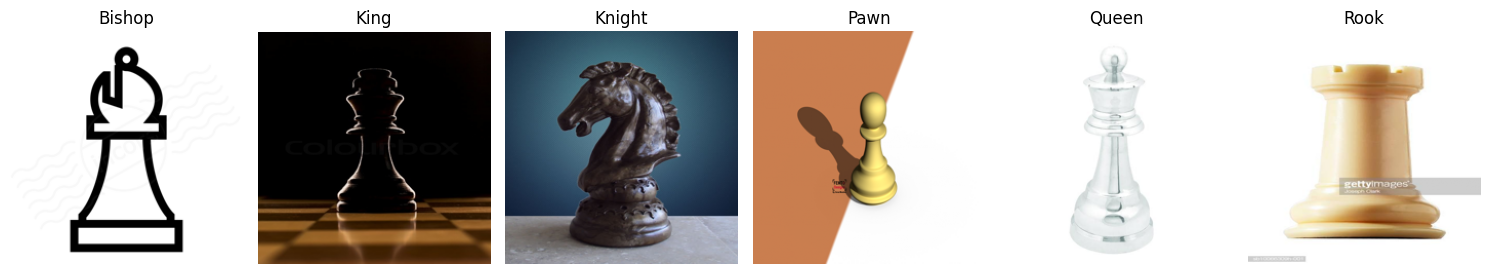

In [7]:
# Plotting example: Plot one example image from each class
num_classes = len(class_names)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

for i, class_name in enumerate(class_names):
    class_indices = np.where(labels == i)[0]
    example_image = images[class_indices[0]]
    axes[i].imshow(example_image)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Set up the directory paths
train_data_dir = '/content/Group 1.0/Chess Dataset'
valid_data_dir = '/content/Group 1.0/Chess Dataset'

# Create ImageDataGenerator instances for training and validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Using 20% of data for validation
)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [9]:
# Generate batches of augmented image data for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 442 images belonging to 6 classes.


In [10]:
validation_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 109 images belonging to 6 classes.


In [11]:
# Create a sequential model
model = Sequential()

In [12]:
# 1st Convolutional Layer
model.add(Conv2D(filters=32, input_shape=(227,227,3), kernel_size=(11,11), activation='relu', strides=(4,4)))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', strides=(1,1), padding='same'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# Flatting
model.add(Flatten())

# Passing it to a Fully Connected layer
# 1st FC Layer
model.add(Dense(4096, activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

# 2nd FC Layer
model.add(Dense(4096, activation='relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))

# 3rd Output Layer
model.add(Dense(6, activation='softmax'))

In [13]:
# Display a summary of the model architecture, including the number of parameters in each layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 32)        11648     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 27, 27, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                        

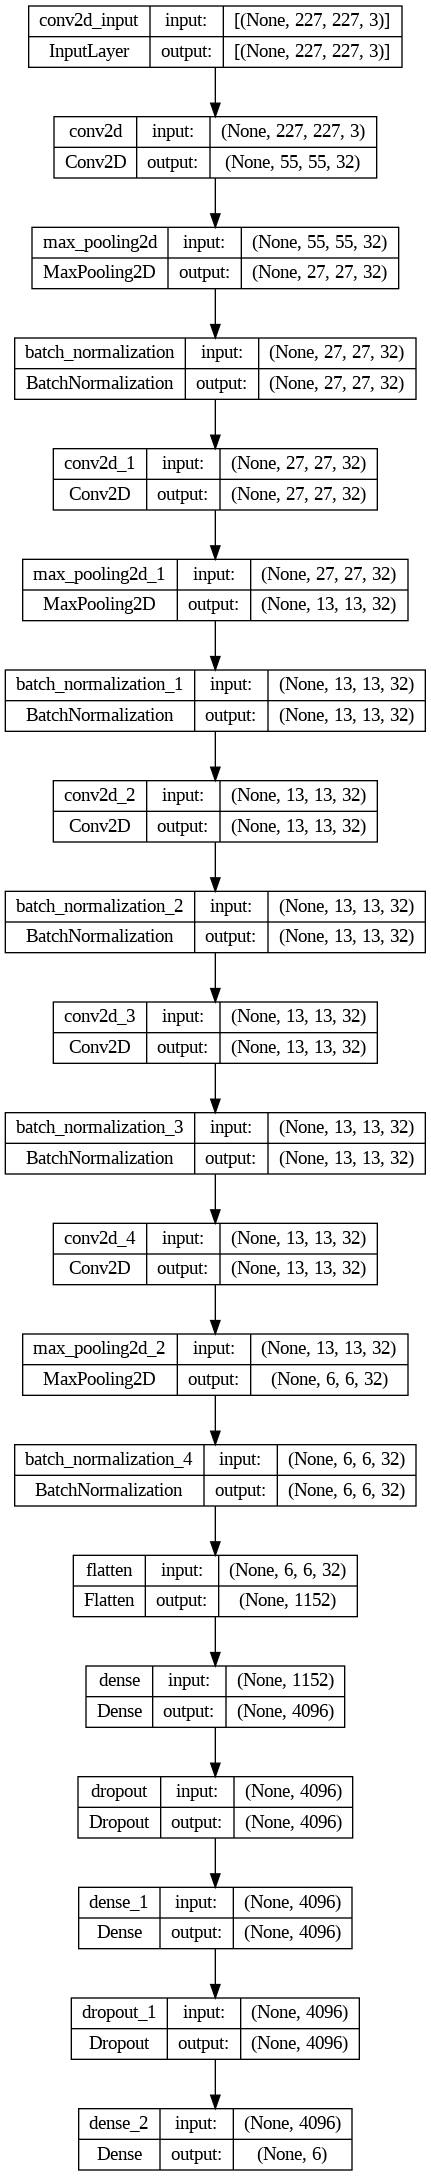

In [14]:
# Visualize the architecture of the model with its layer shapes
utils.plot_model(model, show_shapes=True)

In [15]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['acc'])

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
13/13 [==============================] - 27s 2s/step - loss: 5.3391 - acc: 0.1683 - val_loss: 1.9349 - val_acc: 0.1771
Epoch 2/10
13/13 [==============================] - 20s 2s/step - loss: 2.3883 - acc: 0.2463 - val_loss: 1.9879 - val_acc: 0.1771
Epoch 3/10
13/13 [==============================] - 22s 2s/step - loss: 2.2625 - acc: 0.2463 - val_loss: 2.1634 - val_acc: 0.1250
Epoch 4/10
13/13 [==============================] - 24s 2s/step - loss: 1.7479 - acc: 0.3415 - val_loss: 2.0044 - val_acc: 0.1667
Epoch 5/10
13/13 [==============================] - 20s 2s/step - loss: 1.5963 - acc: 0.3805 - val_loss: 1.7571 - val_acc: 0.2500
Epoch 6/10
13/13 [==============================] - 23s 2s/step - loss: 1.5219 - acc: 0.4098 - val_loss: 1.7849 - val_acc: 0.2500
Epoch 7/10
13/13 [==============================] - 20s 2s/step - loss: 1.5189 - acc: 0.4317 - val_loss: 1.9320 - val_acc: 0.2396
Epoch 8/10
13/13 [==============================] - 21s 2s/step - loss: 1.3570 - acc: 0.45

In [17]:
# Evaluate the model on the validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {validation_accuracy*100:.2f}%')

4/4 [==============================] - 2s 521ms/step - loss: 2.0632 - acc: 0.2477
Validation Accuracy: 24.77%


In [18]:
# Printing the training history containing the loss and accuracy metrics
print(history.history)

{'loss': [5.339118957519531, 2.3882877826690674, 2.2624623775482178, 1.7478537559509277, 1.596347689628601, 1.5218875408172607, 1.518928050994873, 1.3570010662078857, 1.2556160688400269, 1.1402531862258911], 'acc': [0.16829268634319305, 0.24634146690368652, 0.24634146690368652, 0.3414634168148041, 0.3804877996444702, 0.4097560942173004, 0.43170732259750366, 0.4560975730419159, 0.502439022064209, 0.5756097435951233], 'val_loss': [1.934861660003662, 1.987902283668518, 2.16335129737854, 2.004370927810669, 1.7571367025375366, 1.7848819494247437, 1.9319566488265991, 1.7543684244155884, 1.7256122827529907, 2.092924118041992], 'val_acc': [0.1770833283662796, 0.1770833283662796, 0.125, 0.1666666716337204, 0.25, 0.25, 0.2395833283662796, 0.3020833432674408, 0.3125, 0.25]}


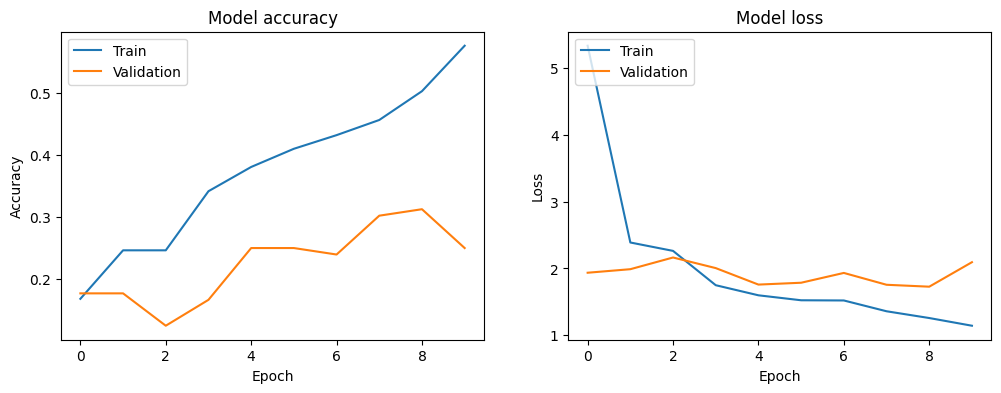

In [19]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [20]:
# Save the model in .h5 extension
model.save('alexnet_chess.h5')

In [21]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('alexnet_chess.h5')

In [22]:
# Test the loaded model on new data (example)
test_data_dir = '/content/Group 1.0/Chess Dataset'
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical'
)

Found 551 images belonging to 6 classes.


In [23]:
# Evaluate the loaded model on test data
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

18/18 [==============================] - 8s 400ms/step - loss: 2.0112 - acc: 0.2740
Test Accuracy: 27.40%
